In [10]:
import torch
import numpy as np
from torch import nn,optim
import time
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

In [40]:
def get_data_ch7():
    data=np.genfromtxt(r'F:\study\ml\DataSet\airfoil_self_noise\airfoil_self_noise.dat',
                      delimiter='\t')
    data=(data-data.mean(axis=0)) / data.std(axis=0)
    features=torch.tensor(data[:1500,:-1],dtype=torch.float32)
    labels=torch.tensor(data[:1500,-1],dtype=torch.float32)
    return features,labels

In [41]:
features,labels=get_data_ch7()
features.shape

torch.Size([1500, 5])

In [42]:
def init_adam_states():
    s_w=torch.zeros((features.shape[1],1),dtype=torch.float32)
    s_b=torch.zeros((1),dtype=torch.float32)
    v_w=torch.zeros((features.shape[1],1),dtype=torch.float32)
    v_b=torch.zeros((1),dtype=torch.float32)
    return ((v_w,s_w),(v_b,s_b))
    

def adad_sge(params,states,hyperparams):
    beta1,beta2,t=0.9,0.999,hyperparams['t']
    eps=1e-6
    for p,(v,s) in zip(params,states):
        v=beta1*v+(1-beta1)*p.grad.data
        s=beta2*s+(1-beta2)*p.grad.data**2
        v_hat=v/(1-beta1**t)
        s_hat=s/(1-beta2**t)
        g_hat=hyperparams['lr']*v_hat /(torch.sqrt(s_hat)+eps)
        p.data -=g_hat

In [43]:
def linreg(x,w,b):
    return torch.mm(x,w)+b
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.shape))**2 

In [44]:
def train_ch7(optimizer_fn,states,hyperparams,features,labels,
              batch_size=10,num_epochs=2):
    net,loss=linreg,squared_loss
    w = nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)),
                     dtype=torch.float32,
                     requires_grad=True))
    b = nn.Parameter(
        torch.tensor(np.zeros(1), dtype=torch.float32, requires_grad=True))
    
    data_iter=torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(features,labels),batch_size=batch_size,
    shuffle=True)
    
    def eval_loss():
        return loss(net(features,w,b),labels).mean().item()/2  + 0.5*hyperparams['lr'] * ((w**2).sum())
    
    ls=[eval_loss()]
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=loss(net(X,w,b),y).mean()/2 + 0.5*hyperparams['lr'] * ((w**2).sum())
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            optimizer_fn([w,b],states,hyperparams)
            if (batch_i+1)*batch_size %100 ==0:
                ls.append(eval_loss())
    print('loss : %f, %f sec per epoch' % (ls[-1],time.time()/num_epochs))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs')
    plt.ylabel('loss')

loss : 0.252874, 810220286.614789 sec per epoch


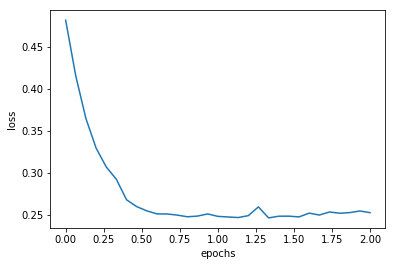

In [48]:
train_ch7(adad_sge, init_adam_states(), {'lr': 0.01, 't': 1},features, labels)

loss : 0.247748, 810218911.070122 sec per epoch


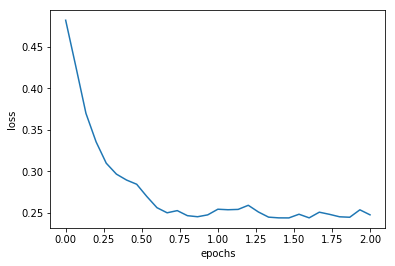

In [17]:
train_ch7(adad_sge, init_adam_states(), {'lr': 0.01, 't': 1},
features, labels)

In [18]:
import csv
import os
from torch.utils.data import Dataset, DataLoader
myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [19]:
class COVID19Dataset(Dataset):
    def __init__(self,path,mode='train',target_only=False):
        self.mode=mode
        with open(path,'r') as fp:
            data=list(csv.reader(fp))
            data=np.array(data[1:])[1:][:,1:].astype(float)
        
        if not target_only:
            feats=list(range(93))
        else:
            pass
        if mode =='test':
            data=data[:,feats]
            self.data=torch.FloatTensor(data)
            
        else:
            target=data[:,-1]
            data=data[:,feats]
            
            if mode=='train':
                indices=[i for i in range(len(data)) if i %10 !=0]
            elif mode=='dev':
                indices=[i for i in range(len(data)) if i %10 ==0]
            
            self.data=torch.FloatTensor(data[indices])
            self.target=torch.FloatTensor(target[indices])
            
        self.data[:,40:]= \
        (self.data[:,40:]-self.data[:,40:].mean(dim=0,keepdim=True)) \
        /self.data[:,40:].std(dim=0,keepdim=True)
        
        self.dim=self.data.shape[1]
        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
        .format(mode, len(self.data), self.dim))
        
    def __getitem__(self,index):
        if self.mode in ['train','dev']:
            return self.data[index],self.target[index]
        else:
            return self.data[index]
        
    def __len__(self):
        return len(self.data)
        
            

In [20]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader
tr_path=r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.train.csv'
tt_path=r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.test.csv'

In [21]:
target_only=False

config={
    'n_epochs':3000,
    'batch_size':270,
    'optimizer':'SGD',
    'optim_hparas':{
        'lr':0.001,
        'momentum':0.9
    },
    'early_stop':200,
    'save_path':r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\models\model',
}

In [22]:
tr_set=prep_dataloader(tr_path,'train',config['batch_size'],target_only=target_only)
dv_set=prep_dataloader(tr_path,'dev',config['batch_size'],target_only=target_only)
tt_set=prep_dataloader(tt_path,'test',config['batch_size'],target_only=target_only)

Finished reading the train set of COVID19 Dataset (2429 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (892 samples found, each dim = 93)


In [23]:
def get_data_dev_set():
    data=np.genfromtxt(r'F:\study\ml\HonyiLee2021\Lhy_Machine_Learning-main\01 Introduction\dataset\covid.test.csv',
                      delimiter=',',skip_header=1)
    data=(data-data.mean(axis=0)) / data.std(axis=0)
    features=torch.tensor(data[:,:-1],dtype=torch.float32)
    labels=torch.tensor(data[:,-1],dtype=torch.float32)
    return features,labels

In [24]:
features,labels=get_data_dev_set()
features.shape

torch.Size([893, 93])

In [25]:
def init_adam_states():
    s_w=torch.zeros((features.shape[1],1),dtype=torch.float32)
    s_b=torch.zeros((1),dtype=torch.float32)
    v_w=torch.zeros((features.shape[1],1),dtype=torch.float32)
    v_b=torch.zeros((1),dtype=torch.float32)
    return ((v_w,s_w),(v_b,s_b))
    

def adad_sge(params,states,hyperparams):
    beta1,beta2,t=0.9,0.999,hyperparams['t']
    eps=1e-6
    for p,(v,s) in zip(params,states):
        v=beta1*v+(1-beta1)*p.grad.data
        s=beta2*s+(1-beta2)*p.grad.data**2
        v_hat=v/(1-beta1**t)
        s_hat=s/(1-beta2**t)
        g_hat=hyperparams['lr']*v_hat /(torch.sqrt(s_hat)+eps)
        p.data -=g_hat


In [37]:
def train_ch7(optimizer_fn,states,hyperparams,tr_set,features,labels,
              batch_size=10,num_epochs=2):
    net,loss=linreg,squared_loss
    w = nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)),
                     dtype=torch.float32,
                     requires_grad=True))
    b = nn.Parameter(
        torch.tensor(np.zeros(1), dtype=torch.float32, requires_grad=True))
    
#     data_iter=torch.utils.data.DataLoader(
#     torch.utils.data.TensorDataset(features,labels),batch_size=batch_size,
#     shuffle=True)
    
    def eval_loss():
        return loss(net(features,w,b),labels).mean().item()/2 + 0.5*hyperparams['lr'] * ((w**2).sum())
    
    ls=[eval_loss()]
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(tr_set):
            l=loss(net(X,w,b),y).mean()/2 + 0.5*hyperparams['lr'] * ((w**2).sum())
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            optimizer_fn([w,b],states,hyperparams)
#             if (batch_i+1)*batch_size %100 ==0:
        ls.append(eval_loss())
    print('loss : %f, %f sec per epoch' % (ls[-1],time.time()/num_epochs))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs')
    plt.ylabel('loss')

loss : 153.992767, 8102201.958856 sec per epoch


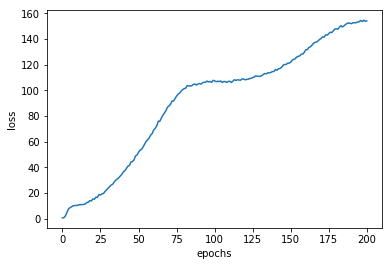

In [39]:
train_ch7(adad_sge, init_adam_states(), {'lr': 0.01, 't': 1},tr_set,features, labels,batch_size=270,num_epochs=200)